# 빅데이터처리
## 2016003709 윤가영

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Misc Functions

In [2]:
def create_dataset(N, minval=[0, 0], maxval=[1, 1]):
    dataset = np.zeros((N, 3))

    x_data = np.random.rand(N) * (maxval[0] - minval[0]) + minval[0]
    y_data = np.random.rand(N) * (maxval[1] - minval[1]) + minval[1]

    dataset[:, 0] = np.arange(N)
    dataset[:, 1] = x_data
    dataset[:, 2] = y_data

    return dataset

def plot_dataset(dataset):
    plt.figure(figsize=(8, 8))
    plt.scatter(dataset[:, 1], dataset[:, 2])
    plt.show()


def sort_dataset(dataset, axis="x"):
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2

    N = dataset.shape[0] 
    datapoints = []
    for i in range(N):
        datapoints.append(list(dataset[i]))

    sorted_dataset = np.stack(list(sorted(datapoints, key=lambda p: p[axis])))

    return sorted_dataset

In [3]:
def compute_median(dataset, axis="x"):
    """
    주어진 데이터포인트에 대해 median 값 반환
    """
    
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2
        
    median = np.median(dataset[:, axis])
    
    return median

In [4]:
def compute_distance(p1, p2):
    """
    주어진 2개 데이터포인트에 대해 거리 계산
    """
    
    distance = np.sqrt(np.sum((p1[1:] - p2[1:])**2))
    return distance

In [5]:
def get_median_points(sorted_dataset, median, d, axis="x"):
    """
    Median 근처의 데이터포인트(좌우 d 이하로 떨어진) 찾아서 반환
    MOTE: sorted_dataset은 axis와 반대 축으로 정렬된 리스트여야 함
          -> 여기서는 항상 y_sorted_dataset
    """
    
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2
    
    filtered_dataset = sorted_dataset[
        (sorted_dataset[:, axis] >= median - d) & (sorted_dataset[:, axis] <= median + d)
    ]
    return filtered_dataset

#### 기울기를 측정하여 세점이 일직선을 이루거나 한점일 경우 false를, 아니면  true를 반환한다.

In [6]:
def compute_gradient(p1, p2, p3):
    if(p1[1]==p2[1]==p3[1] and p1[2]==p2[2]==p3[2]):
        return False
    grad1 = (p1[2] - p2[2]) / (p1[1] - p2[1])
    grad2 = (p1[2] - p3[2]) / (p1[1] - p3[1])
    grad3 = (p2[2] - p3[2]) / (p2[1] - p3[1])
    return False if (grad1==grad2==grad3) else True

# Merge

메디안 앞뒤로 왼쪽, 오른쪽 구역에 걸쳐있는 점의 쌍의 거리를 계산한다.

In [7]:
def compute_median_closest_trip(median_datapoints, d, along_axis="y"):
    """
    Median 근처 데이터포인트들에서 closest trip 계산 -> merge
    """
    
    if along_axis == "x":
        along_axis = 1
    elif along_axis == "y":
        along_axis = 2
    
    N = median_datapoints.shape[0]
    min_distance = d
    closest_point_trip = None
    
    if N > 0:
        # y축 기준 제일 작은 포인트부터 루프
        for i in range(N):
            dp = median_datapoints[i]

            filtered_median_datapoints = []
            
            for j in range(i+1, N): 
                
                for k in range(j+1, N):
                    filtered_median_pair = []
                    
                    p1 = median_datapoints[j]
                    p2 = median_datapoints[k]
                    
                    # 현재 데이터포인트부터 y축 값이 큰 값의 데이터포인트를 차례대로 얻어오고, 그 값이 범위내에 있는지 검사
                    if (p1[along_axis] <= dp[along_axis] + d) and (p2[along_axis] <= dp[along_axis] + d) and\
                        compute_gradient(dp,p1,p2):
                        filtered_median_pair.append(p1)
                        filtered_median_pair.append(p2)
                        
                        filtered_median_datapoints.append(filtered_median_pair)
                    
                    # 범위내에 없으면 더 검사할 필요 없이 break   
                    else:
                        break
            
            if len(filtered_median_datapoints) == 0:
                    continue
                
            # 편의를 위해 numpy array로 바꿔주는 코드
            filtered_median_datapoints = np.stack(filtered_median_datapoints, axis=0)

            # 걸러진 포인트개수
            M = filtered_median_datapoints.shape[0]

            # closest trip 계산
            for j in range(M):
                p1 = filtered_median_datapoints[j][0]
                p2 = filtered_median_datapoints[j][1]
                
                d1 = compute_distance(dp, p1)
                d2 = compute_distance(dp, p2)
                d3 = compute_distance(p1, p2)
                
                dist = d1 + d2 + d3

                if dist < min_distance:
                    min_distance = dist
                    closest_point_trip = (dp, p1, p2)
                
    return closest_point_trip

# Divide-and-Conquer Algorithm

In [8]:
def compute_closest_trip(x_sorted_dataset, y_sorted_dataset):
    """
    Closest trip 계산 알고리즘
    """
    
    N = x_sorted_dataset.shape[0]
    if N <= 2:                  # 해당 영역에 데이터포인트가 하나 혹은 2개밖에 없는 경우
        return None
    
    elif N == 3 :               # 해당 영역에 데이터포인트가 3개있는 경우
        p1 = x_sorted_dataset[0]
        p2 = x_sorted_dataset[1]
        p3 = x_sorted_dataset[2]
        
        #p1~p3가 같은점이거나, 한직선위에 있지 않다면 3쌍 반환
        if(compute_gradient(p1,p2,p3)):
            return (p1, p2, p3)
        else:
            return None
    
    else:                       # 해당 영역에 데이터포인트가 3개 초과인 경우
        # median 값 계산
        x_median = compute_median(x_sorted_dataset, axis="x")
        
        # median 값 기준으로 좌우로 데이터셋을 나눔
        dataset_left_x = x_sorted_dataset[x_sorted_dataset[:, 1] <= x_median]
        dataset_right_x = x_sorted_dataset[x_sorted_dataset[:, 1] > x_median]
        
        dataset_left_y = y_sorted_dataset[y_sorted_dataset[:, 1] <= x_median]
        dataset_right_y = y_sorted_dataset[y_sorted_dataset[:, 1] > x_median]
        
        # 좌우 영역에서 각각 closest trip 계산
        trip_left = compute_closest_trip(dataset_left_x, dataset_left_y)
        trip_right = compute_closest_trip(dataset_right_x, dataset_right_y)

        
        if trip_left is None:  # 좌측 영역에 데이터포인트가 1개 혹은 2개밖에 없었을 경우
            min_distance_left = np.inf
        else:
            d1 = compute_distance(trip_left[0], trip_left[1])
            d2 = compute_distance(trip_left[0], trip_left[2])
            d3 = compute_distance(trip_left[1], trip_left[2])
            min_distance_left = d1 + d2 + d3
            
        if trip_right is None: # 우측 영역에 데이터포인트가 1개 혹은 2개밖에 없었을 경우
            min_distance_right = np.inf
        else:
            d1 = compute_distance(trip_right[0], trip_right[1])
            d2 = compute_distance(trip_right[0], trip_right[2])
            d3 = compute_distance(trip_right[1], trip_right[2])
            min_distance_right = d1 + d2 + d3
        
        min_distance = np.inf
        # 좌우측의 closest trip 바탕으로 전체(?) closest trip 계산
        if min_distance_left < min_distance_right:
            min_distance = min_distance_left
            closest_trip = trip_left
        elif min_distance_left > min_distance_right:
            min_distance = min_distance_right
            closest_trip = trip_right
        
        # median 근처의 데이터포인트만 얻어옴
        median_points = get_median_points(y_sorted_dataset, x_median, min_distance, axis="x")
        
        # median 근처 포인트들 중에서 closest trip 계산
        median_closest_trip = compute_median_closest_trip(median_points, min_distance, along_axis="y")
        
        # closest trip가 median 근처에 있었을 경우, global closest trip 업데이트
        if median_closest_trip is not None:
            closest_trip = median_closest_trip
        
        return closest_trip

# Test

In [9]:
dataset = create_dataset(N=100)
x_sorted_dataset = sort_dataset(dataset, axis="x")
y_sorted_dataset = sort_dataset(dataset, axis="y")

trip = compute_closest_trip(x_sorted_dataset, y_sorted_dataset)
print(trip)

(array([45.        ,  0.2116222 ,  0.20463105]), array([83.        ,  0.1989095 ,  0.20589384]), array([62.        ,  0.2051137 ,  0.21855651]))


In [10]:
trip

(array([45.        ,  0.2116222 ,  0.20463105]),
 array([83.        ,  0.1989095 ,  0.20589384]),
 array([62.        ,  0.2051137 ,  0.21855651]))

In [11]:
def check(dataset):
    N = dataset.shape[0]
    
    min_tri = np.inf
    closest_trip = None
    
    for i in range(N):
        for j in range(i + 1, N):
            for k in range(j + 1 , N):
                p1 = dataset[i]
                p2 = dataset[j]
                p3 = dataset[k]
                
                if(compute_gradient(p1,p2,p3)):
                    d1 = compute_distance(p1, p2)
                    d2 = compute_distance(p2, p3)
                    d3 = compute_distance(p1, p3)

                    tri = d1 + d2 + d3

                    if tri < min_tri:
                        min_tri = tri
                        closest_trip = (p1, p2, p3)
                
    return closest_trip

In [12]:
trip_check = check(dataset)
print(trip_check)

(array([45.        ,  0.2116222 ,  0.20463105]), array([62.        ,  0.2051137 ,  0.21855651]), array([83.        ,  0.1989095 ,  0.20589384]))


In [13]:
import sys

부동 소수점으로 인한 오차를 없애기 위해 두 결과값의 차이가 앱실론보다 착으면 true를 반환한다.<br/>
실제로 똑같은 좌표가 추출됐지만, 부동소수점으로 인해 틀리다고 나왔고, 두결과값의 오차가 앱실론보다 작을때만 허용했더니 테스트 성공을 이루었다.

In [14]:
def compare_floating_point(approx, actual):
    return (True if abs(approx - actual) <= sys.float_info.epsilon else False)

In [15]:
def unit_test(n_iter):
    for i in range(n_iter):
        test_dataset = create_dataset(N=100)
        x_sorted_test_dataset = sort_dataset(test_dataset, axis="x")
        y_sorted_test_dataset = sort_dataset(test_dataset, axis="y")

        trip1 = compute_closest_trip(x_sorted_test_dataset, y_sorted_test_dataset)
        trip2 = check(test_dataset)
        
        d1 = compute_distance(trip1[0], trip1[1])
        d2 = compute_distance(trip1[1], trip1[2])
        d3 = compute_distance(trip1[0], trip1[2])
        tri1 = d1 + d2 + d3

        d1 = compute_distance(trip2[0], trip2[1])
        d2 = compute_distance(trip2[1], trip2[2])
        d3 = compute_distance(trip2[0], trip2[2])
        tri2 = d1 + d2 + d3
        
        assert compare_floating_point(tri1,tri2), f"테스트실패! trip1: {trip1}, trip2: {trip2}, distance: {tri1}, {tri2}"
        
    print("테스트성공")

In [16]:
unit_test(10)

테스트성공


# 실행시간 그래프

In [17]:
def test_with_n(N):
    dataset = create_dataset(N)
    
    start_time = time.time()
    x_sorted_test_dataset = sort_dataset(dataset, axis="x")
    y_sorted_test_dataset = sort_dataset(dataset, axis="y")
    
    closest_pair = compute_closest_trip(x_sorted_test_dataset, y_sorted_test_dataset)
    duration = time.time() - start_time
    
    return duration

In [18]:
def test_naive_with_n(N):
    dataset = create_dataset(N)
    start_time = time.time()
    closest_pair = check(dataset)
    duration = time.time() - start_time
    
    return duration

In [19]:
Ns = [100, 500, 1000, 5000, 10000, 50000, 100000]

durations = []
for n in Ns:
    duration = 0.0
    for i in range(3):
        duration += test_with_n(n)
        
    durations.append(duration/3)

#### [500개, 1000개] 코드실행시, 각각 30분을 훌쩍 넘겨서 500과 1000의 코드동작을 skip

In [20]:
naive_Ns = [100, 500, 1000]

naive_durations = []
for n in naive_Ns:
    duration = 0.0
    if(n==1000 or n==500):
        continue
    for i in range(3):
        duration += test_naive_with_n(n)
        
    naive_durations.append(duration/3)

In [21]:
naive_durations

[8.261820316314697]

#### 대신 임의로 [500개, 1000개]에 대한 실행시간을 40분 걸렸다고 넣어, 아래 그래프에서 30분까지만 보이도록 설정

In [22]:
naive_durations.append(400.)
naive_durations.append(400.)

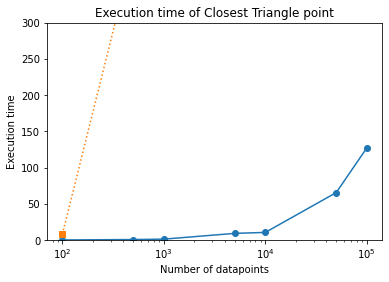

In [23]:
#plt.figure(figsize=(8, 8))
plt.plot(Ns, durations, linestyle='-', marker='o')
plt.plot(naive_Ns, naive_durations, linestyle=':', marker='s')
plt.ylim(0,300)
plt.xlabel("Number of datapoints")
plt.ylabel("Execution time")
plt.title("Execution time of Closest Triangle point")
plt.xscale('log')
plt.show()